## Human Activity Recognition System using Machine Learning techniques for Home Automation by Leon Vitanos

Dataset used: https://tev.fbk.eu/technologies/smartwatch-gestures-dataset

Eight different users performed twenty repetitions of twenty different gestures, for a total of 3200 sequences. Each sequence contains acceleration data from the 3-axis accelerometer of a first generation Sony SmartWatch™, as well as timestamps from the different clock sources available on an Android device. The smartwatch was worn on the user's right wrist. The gestures have been manually segmented by the users performing them by tapping the smartwatch screen at the beginning and at the end of every repetition.

<img src="gestures.png">



### Load and preprocess dataset
We use the first 8 Haar transformation coefficients for each axis, creating a 24 vector for each sequence

In [4]:
import numpy as np
import pandas as pd
import os
import pywt

print("Loading and preprocessing dataset...")
training_data_all_gestures = []
training_data_six_gestures = []
users = ["U01", "U02", "U03", "U04", "U05", "U06", "U07", "U08"]
gestures = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10",
            "11", "12", "13", "14", "15", "16", "17", "18", "19", "20"]

def haar_transform(sequence_array):
    x = np.concatenate((pywt.wavedec(sequence_array.iloc[:,0], 'db1', level=3)))
    y = np.concatenate((pywt.wavedec(sequence_array.iloc[:,1], 'db1', level=3)))
    z = np.concatenate((pywt.wavedec(sequence_array.iloc[:,2], 'db1', level=3)))
    xyz = np.concatenate((x[:8],y[:8],z[:8]))
    return xyz

for user in users:
    user_path = os.path.join("gestures-dataset", user)
    for gesture in gestures:
        class_num = gestures.index(gesture)
        path = os.path.join(user_path, gesture)
        for sequence in os.listdir(path):
            sequence_array = pd.read_csv(os.path.join(path, sequence), sep=" ", header=None, usecols=[3, 4, 5])
            training_data_all_gestures.append([haar_transform(sequence_array),class_num])
            if class_num<=5:
                training_data_six_gestures.append([haar_transform(sequence_array),class_num])
                
print("In total", len(training_data_all_gestures), "sequences have been loaded and preprocessed")

Loading and preprocessing dataset...
In total 3251 sequences have been loaded and preprocessed


### Load features and labels

In [5]:
#For all gestures
X = []
y = []

for features, label in training_data_all_gestures:
    X.append(features)
    y.append(label)

#For the first 6 gestures
X6 = []
y6 = []

for features, label in training_data_six_gestures:
    X6.append(features)
    y6.append(label)

### Split training/validation/test set

In [6]:
X_train = X[:2449]
X_test = X[2450:]
y_train = y[:2449]
y_test = y[2450:]

X6_train = X[:735]
X6_test = X[736:]
y6_train = y[:735]
y6_test = y[736:]

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
X6_train, X6_val, y6_train, y6_val = train_test_split(X6_train, y6_train, test_size=0.2, random_state=1)

## Find best model
We will find the best model using the following algorithms:
- K-nearest neighbors 
- Decision Tree
- Random Forest
- MLP
- CNN
- LSTM/RNN

In [128]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def predict_accuracy_and_f1():  
    y_pred = model.predict(X_test)
    acc = metrics.accuracy_score(y_test, y_pred)
    accTest.append(acc)
    f1 = metrics.f1_score(y_test, y_pred, average="macro", labels=np.unique(y_pred))
    f1Test.append(f1)
      
    y_pred = model.predict(X6_test)
    acc = metrics.accuracy_score(y6_test, y_pred)
    accTest6.append(acc)
    f1 = metrics.f1_score(y6_test, y_pred, average="macro", labels=np.unique(y_pred))
    f1Test6.append(f1)
       
def print_and_plot_results(model, argument):  
    plt.figure(figsize=(14,6))
    
    plt.subplot(2, 2, 1)
    plt.plot(lnS,f1Test6, label="Using the first 6 gestures")
    plt.plot(lnS,f1Test, label="Using all gestures")
    plt.title("F1 Macro")
    plt.xlabel(argument)
    plt.legend(loc='lower right')
    
    plt.subplot(2, 2, 3)
    plt.plot(lnS,accTest6, label="Using the first 6 gestures")
    plt.plot(lnS,accTest, label="Using all gestures")
    plt.title("Accuracy")
    plt.xlabel(argument)
    plt.legend(loc='lower right')
    
    plt.subplot(1, 2, 2)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(
        cm, index=range(0, 20), columns=range(0, 20), 
    )
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.tight_layout()
    plt.show()  
    
    print("Max f1 score using all gestures is {:.3f}".format(max(f1Test)),
      "using",f1Test.index(max(f1Test)),"as", argument,end=".\n")
    print("Max f1 score using the first 6 gestures is {:.3f}".format(max(f1Test6)),
      "using",f1Test6.index(max(f1Test6)),"as", argument,end=".")

### Decision Tree

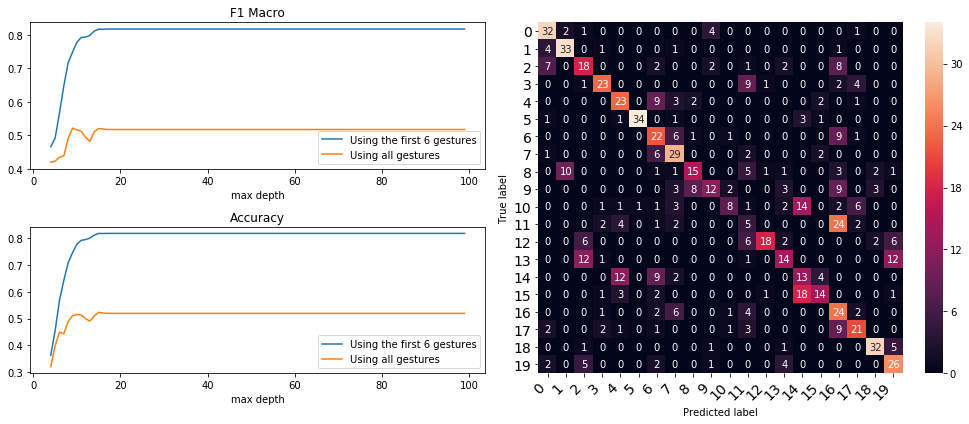

Max f1 score using all gestures is 0.522 using 5 as max depth.
Max f1 score using the first 6 gestures is 0.818 using 13 as max depth.

In [129]:
from sklearn.tree import DecisionTreeClassifier

accTrain, accTest, accVal, accTrain6, accTest6, accVal6 = ([] for i in range(6))
f1Train, f1Test, f1Val, f1Train6, f1Test6, f1Val6, lnS = ([] for i in range(7))

for ln in range(4,100):
    lnS.append(ln)
    model = DecisionTreeClassifier(max_depth=ln, random_state=0)
    model.fit(X_train, y_train)
    predict_accuracy_and_f1()

model = DecisionTreeClassifier(max_depth=ln, random_state=0)
model.fit(X_train, y_train)
print_and_plot_results(model,"max depth")

### Random Forest